# ECE M214A Project: Speaker Region Identification



In this project, we'll train a machine learning algorithm to classify speakers by regional dialect.  We will use speech samples from the Corpus of Regional African American Language (CORAAL - https://oraal.uoregon.edu/coraal) with speakers each belonging to one of five different US cities: 1) Rochester, NY (ROC), 2) Lower East Side, Manhattan, NY (LES), 3) Washington DC (DCB), 4) Princeville, NC (PRV), or 5) Valdosta, GA (VLD).

The project files can be downloaded from [this link](https://ucla.box.com/s/d6durcy98r1ti6n97vu0u13pdg2i7xmh)

To do this, we will first extract features from the audio files and then train a classifier to predict the city of origin of the utterance's speaker.  The goal is to extract a feature that contains useful information about regional dialect characteristics.

##1. Setting up the data directories and Google Colab

Store a copy of the project files in your google drive.

Make sure that the 'project_data' folder is stored in the top level of your google drive. Otherwise, you will need to change the corresponding paths in the remainder of the notebook.

Mount your google drive. This will give this notebook read/write access to data stored in your google drive.  You can either do this in the file browser on the left side of this notebook or by running the code snippet below.

It is recommended that you use your UCLA google account for this project, as it has more storage than a standard google account.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(f"In CoLab: {IN_COLAB}")


import os
if(not(os.path.exists('../W24 ECE M214A Project.zip'))):
  if(IN_COLAB):
    !gdown 1abjWNLbLzwJJ2qv_V0CfpfeMzs56sSut
  else:
    print('Please Download The Project Data (W24 ECE M214A Project.zip) and Try Again')
  if(not(os.path.exists('../W24 ECE M214A Project/'))):
    if(IN_COLAB):
      !unzip "W24 ECE M214A Project.zip"
    else:
      print('Please Unzip the Project Data (W24 ECE M214A Project.zip) to ((W24 ECE M214A Project/) and Try Again')
project_dir =  '../W24 ECE M214A Project'

In CoLab: False


To run this project on your local system, replace the corresponding file paths to the locations of the project files on your local machine

## 2. Getting familiar with the data


Let's take a moment to understand the data.  The original CORAAL dataset consists of ~85 different speakers, each from one of five cities.  The audio files are names with the convention: DCB_se1_ag1_f_03.  Here, DCB is the city code, se1 denotes the socioeconomic group of the speaker, ag1 denotes the age group of the speaker, f denotes female, and 03 denotes the participant number.  These unique combinations of identifiers mark the speaker.  

The dataset has been preprocessed to only include audio segments greater than 10 seconds in length. there are a number of audio snippets of at least 10sec in length.  Those segments are numbered with the appending tag _seg_number for each segment.

You can also try listening to any segment like this:

In [3]:
from IPython.display import Audio

sr = 44100

# Audio(filename= "drive/MyDrive/project_data/train_clean/DCB_se1_ag1_f_03_1_seg_3.wav", rate=sr)
Audio(filename= f"{project_dir}/project_data/train_clean/DCB_se1_ag1_f_03_1_seg_3.wav", rate=sr)

The original dataset has also been split into a train and test set. The test set has been further split, with a portion corrupted with the addition of noise:

In [4]:
sr = 44100

# Audio(filename= "drive/MyDrive/project_data/test_noisy/LES_se0_ag3_f_01_1_seg_57.wav", rate=sr)
Audio(filename= f"{project_dir}/project_data/test_noisy/LES_se0_ag3_f_01_1_seg_57.wav", rate=sr)

## 3. Feature Extraction

As a baseline, we will be using the average mfcc value over time from the Librosa Python library. Your job will be to choose better features to improve performance on both the clean and noisy data

We first define a pair of functions to create features and labels for our classification model:


In [5]:
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm


def extract_feature(audio_file, n_mfcc=13, resample=False):

  '''
  Function to extract features from a single audio file given its path
  Modify this function to extract your own custom features
  '''

  audio,fs = torchaudio.load(audio_file)
  audio = audio.numpy().reshape(-1)

  if resample:
    audio = librosa.resample(audio, orig_sr=44100, target_sr=16000)

  # replace the following features with your own
  mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_mfcc)
  feat_out = np.mean(mfccs,axis=1)

  return feat_out


def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

Let us now call these functions to extract the features and labels from the train_clean directory

In [6]:

#First we obtain the list of all files in the train_clean directory
train_files = glob(f'{project_dir}/project_data/train_clean/*.wav')

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat=[]
train_label=[]

for wav in tqdm(train_files):

  train_feat.append(extract_feature(wav))
  train_label.append(get_label(wav))

100%|██████████████████████████████████████████████████████████████████████████████| 4372/4372 [02:54<00:00, 25.03it/s]


In [7]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(f'{project_dir}/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(extract_feature(wav))
  test_clean_label.append(get_label(wav))

100%|████████████████████████████████████████████████████████████████████████████████| 447/447 [00:16<00:00, 27.33it/s]


In [8]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(f'{project_dir}/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat.append(extract_feature(wav))
  test_noisy_label.append(get_label(wav))

100%|████████████████████████████████████████████████████████████████████████████████| 347/347 [00:15<00:00, 23.06it/s]


## 4. Model Training and Predictions

Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

In [9]:
#Install shap library
# !pip install shap

In [74]:
import xgboost
import numpy as np
import shap
import pandas as pd

#Format input data

#Edit this variable to create a list that contains your feature names
feat_names=['mfcc_' +str(n) for n in range(len(train_feat[0]))]

train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.


model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.7695749440715883
Test Noisy Acc = 0.6195965417867435


To save a dataframe of features, uncomment and run the following block of code

In [75]:
feature_dir = f'./features'
if(not(os.path.exists(feature_dir))):
    os.mkdir(feature_dir)
train_feat_df.to_csv(f'{feature_dir}/mfcc13_train.csv')
test_clean_feat_df.to_csv(f'{feature_dir}/mfcc13_test_clean.csv')
test_noisy_feat_df.to_csv(f'{feature_dir}/mfcc13_test_noisy.csv')

To Load a preexisting dataframe of features (saved from a previous notebook), run the following cell and then train the model

In [76]:
train_feat_df = pd.read_csv(f'{feature_dir}/mfcc13_train.csv', index_col = 0)
test_clean_feat_df = pd.read_csv(f'{feature_dir}/mfcc13_test_clean.csv', index_col = 0)
test_noisy_feat_df = pd.read_csv(f'{feature_dir}/mfcc13_test_noisy.csv', index_col = 0)

## 5. Interpreting Results and Explainability

To see the impact different features have on the model, we create a plot of the feature importances. The features are listed top to bottom in order of how important they were to the decision.

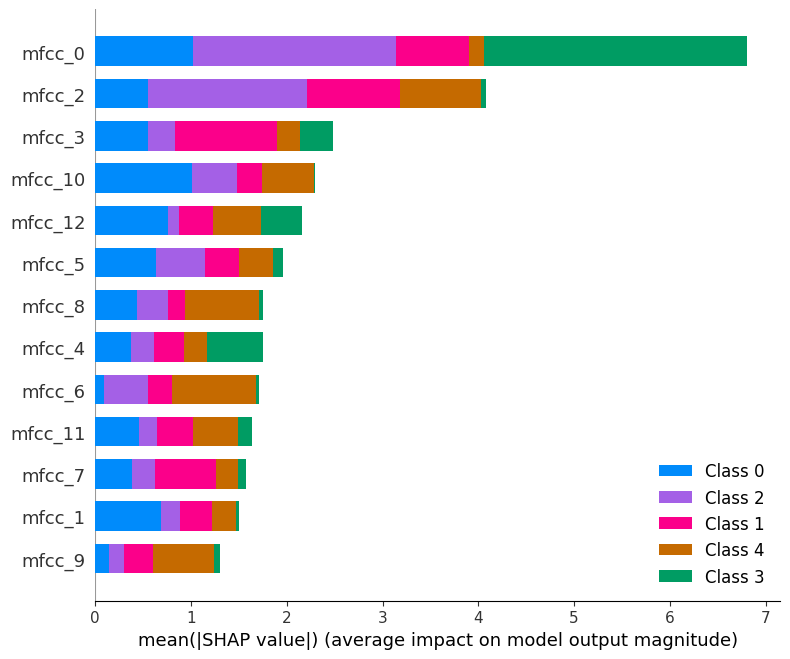

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_df)
shap.summary_plot(shap_values, train_feat_df)

And we can see a confusion matrix of the mispredictions

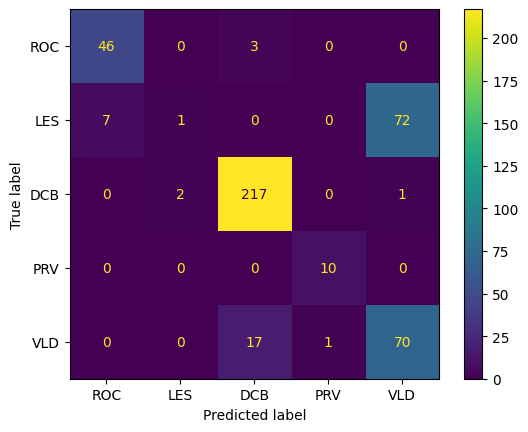

In [63]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

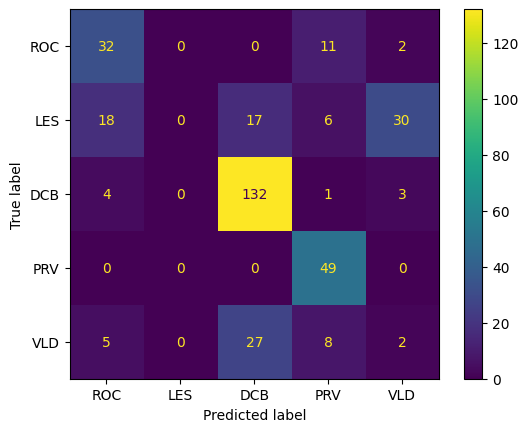

In [15]:

confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

# 6. We now repeat this with resampling

In [16]:
train_feat_rs=[]

for wav in tqdm(train_files):

  train_feat_rs.append(extract_feature(wav, resample=True))

100%|██████████████████████████████████████████████████████████████████████████████| 4372/4372 [01:29<00:00, 48.69it/s]


In [17]:
test_clean_feat_rs = []

for wav in tqdm(test_clean_files):

  test_clean_feat_rs.append(extract_feature(wav, resample=True))

100%|████████████████████████████████████████████████████████████████████████████████| 447/447 [00:08<00:00, 52.58it/s]


In [18]:
test_noisy_feat_rs = []

for wav in tqdm(test_noisy_files):

  test_noisy_feat_rs.append(extract_feature(wav, resample=True))

100%|████████████████████████████████████████████████████████████████████████████████| 347/347 [00:07<00:00, 43.75it/s]


In [19]:
train_feat_rs_df = pd.DataFrame(data=np.stack(train_feat_rs), columns=feat_names)

test_clean_feat_rs_df = pd.DataFrame(data=np.stack(test_clean_feat_rs), columns=feat_names)

test_noisy_feat_rs_df = pd.DataFrame(data=np.stack(test_noisy_feat_rs), columns=feat_names)


model_rs = xgboost.XGBClassifier()
model_rs.fit(train_feat_rs_df,y_train)

print("Train Clean Resample Acc =", np.sum(y_train==model_rs.predict(train_feat_rs_df))/len(y_train))

print("Test Clean Resample Acc =", np.sum(y_test_clean==model_rs.predict(test_clean_feat_rs_df))/len(y_test_clean))

print("Test Noisy Resample Acc =", np.sum(y_test_noisy==model_rs.predict(test_noisy_feat_rs_df))/len(y_test_noisy))


Train Clean Resample Acc = 1.0
Test Clean Resample Acc = 0.9038031319910514
Test Noisy Resample Acc = 0.44668587896253603


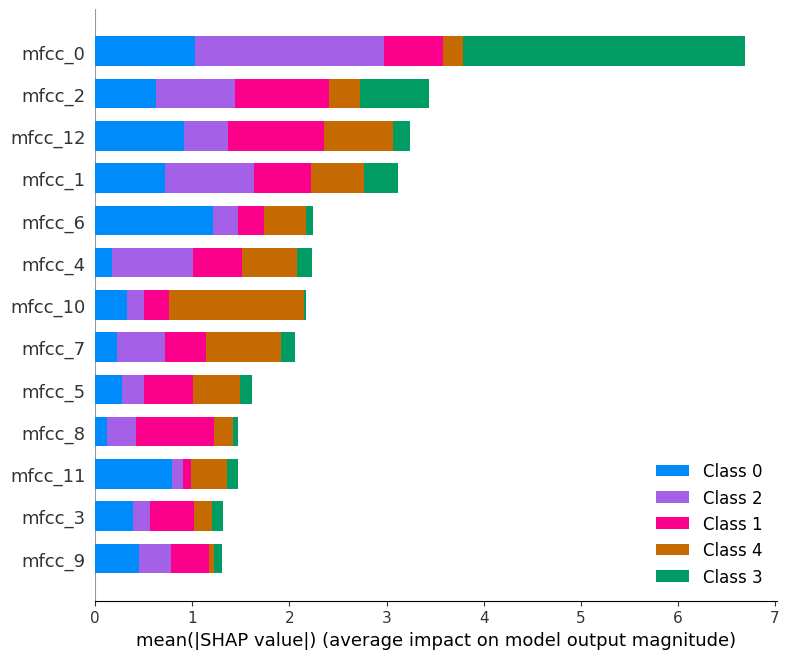

In [20]:
explainer = shap.TreeExplainer(model_rs)
shap_values_rs = explainer.shap_values(train_feat_rs_df)
shap.summary_plot(shap_values_rs, train_feat_rs_df)

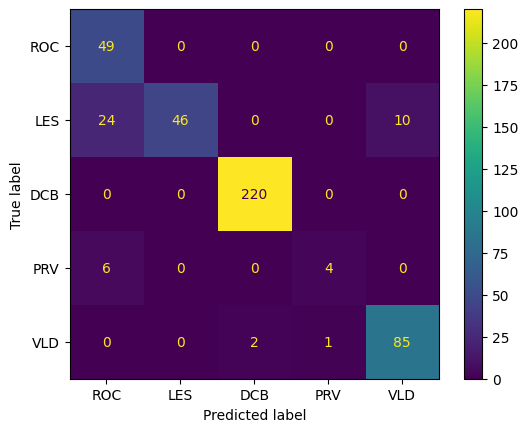

In [21]:
confusion_matrix_clean_rs = metrics.confusion_matrix(y_test_clean, model_rs.predict(test_clean_feat_rs_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean_rs, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

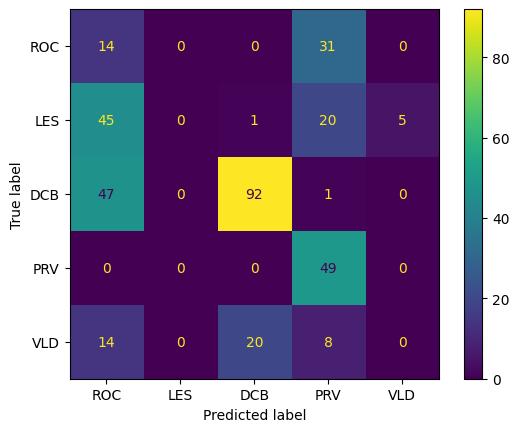

In [22]:
confusion_matrix_noisy_rs = metrics.confusion_matrix(y_test_noisy, model_rs.predict(test_noisy_feat_rs_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy_rs, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

# 7. Using Opensmile

eGeMaps Feature Set:

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7160715

In [23]:
# !pip install opensmile

In [24]:
import opensmile
smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.GeMAPSv01b,
      feature_level=opensmile.FeatureLevel.Functionals,
  )

len(smile.feature_names)

62

In [25]:
smile2 = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
smile2.feature_names

['Loudness_sma3',
 'alphaRatio_sma3',
 'hammarbergIndex_sma3',
 'slope0-500_sma3',
 'slope500-1500_sma3',
 'spectralFlux_sma3',
 'mfcc1_sma3',
 'mfcc2_sma3',
 'mfcc3_sma3',
 'mfcc4_sma3',
 'F0semitoneFrom27.5Hz_sma3nz',
 'jitterLocal_sma3nz',
 'shimmerLocaldB_sma3nz',
 'HNRdBACF_sma3nz',
 'logRelF0-H1-H2_sma3nz',
 'logRelF0-H1-A3_sma3nz',
 'F1frequency_sma3nz',
 'F1bandwidth_sma3nz',
 'F1amplitudeLogRelF0_sma3nz',
 'F2frequency_sma3nz',
 'F2bandwidth_sma3nz',
 'F2amplitudeLogRelF0_sma3nz',
 'F3frequency_sma3nz',
 'F3bandwidth_sma3nz',
 'F3amplitudeLogRelF0_sma3nz']

In [26]:
print(smile.feature_names)

['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'jitterLocal_sma3nz_amean', 'jitterLocal_sma3nz_stddevNorm', 'shimmerLocaldB_sma3nz_amean', 'shimmerLocaldB_sma3nz_stddevNorm', 'HNRdBACF_sma3nz_amean', 'HNRdBACF_sma3nz_stddevNorm', 'logRelF0-H1-H2_sma3nz_amean', 'logRelF0-H1-H2

In [27]:

def extract_smile(wav):

  audio,sample_fs = torchaudio.load(wav)

  sample_audio = audio.numpy().reshape(-1)

  smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.GeMAPSv01b,
      feature_level=opensmile.FeatureLevel.Functionals,
  )
  #opensmile.FeatureSet.ComParE_2016,
  #opensmile.FeatureSet.eGeMAPSv02
  y = smile.process_signal(
      sample_audio,
      sample_fs
  )
  return np.array(y.iloc[0])

In [28]:
extract_smile(wav).shape

(62,)

In [29]:
train_feat_os=[]

for wav in tqdm(train_files):

  train_feat_os.append(extract_smile(wav))

100%|██████████████████████████████████████████████████████████████████████████████| 4372/4372 [47:04<00:00,  1.55it/s]


In [30]:
test_clean_feat_os=[]

for wav in tqdm(test_clean_files):

  test_clean_feat_os.append(extract_smile(wav))

100%|████████████████████████████████████████████████████████████████████████████████| 447/447 [04:22<00:00,  1.70it/s]


In [31]:
test_noisy_feat_os = []

for wav in tqdm(test_noisy_files):

  test_noisy_feat_os.append(extract_smile(wav))

100%|████████████████████████████████████████████████████████████████████████████████| 347/347 [04:23<00:00,  1.32it/s]


In [47]:
feat_names_os  = list(smile.feature_names)

In [66]:
train_feat_os_df = pd.DataFrame(data=np.stack(train_feat_os), columns=feat_names_os)

test_clean_feat_os_df = pd.DataFrame(data=np.stack(test_clean_feat_os), columns=feat_names_os)

test_noisy_feat_os_df = pd.DataFrame(data=np.stack(test_noisy_feat_os), columns=feat_names_os)


model_os = xgboost.XGBClassifier()
model_os.fit(train_feat_os_df,y_train)

print("Train Clean Opensmile Acc =", np.sum(y_train==model_os.predict(train_feat_os_df))/len(y_train))

print("Test Clean Opensmile Acc =", np.sum(y_test_clean==model_os.predict(test_clean_feat_os_df))/len(y_test_clean))

print("Test Noisy Opensmile Acc =", np.sum(y_test_noisy==model_os.predict(test_noisy_feat_os_df))/len(y_test_noisy))


Train Clean Opensmile Acc = 1.0
Test Clean Opensmile Acc = 0.9261744966442953
Test Noisy Opensmile Acc = 0.49279538904899134


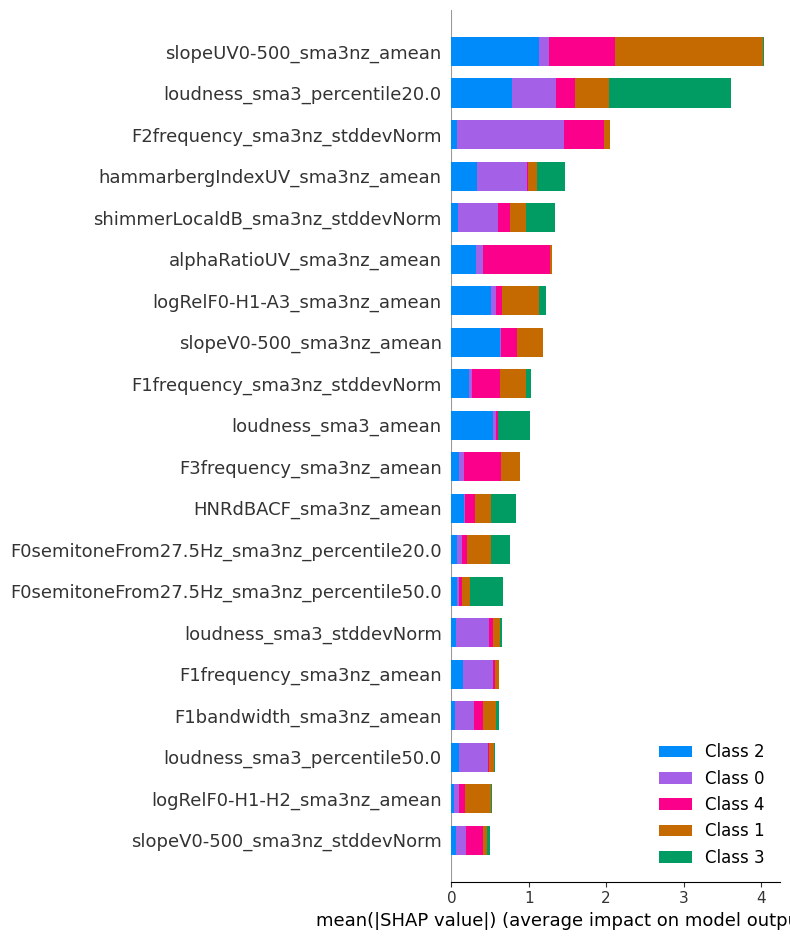

In [68]:
explainer = shap.TreeExplainer(model_os)
shap_values_os = explainer.shap_values(train_feat_os_df)
shap.summary_plot(shap_values_os, train_feat_os_df)

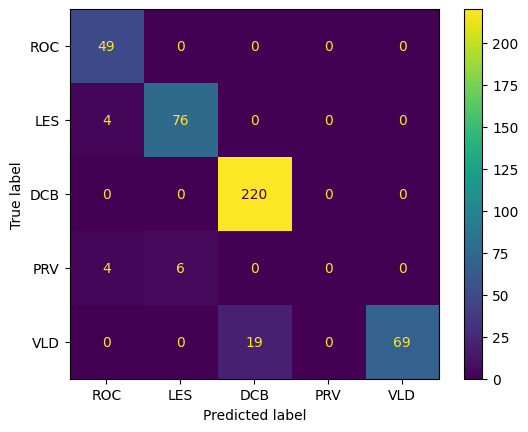

In [69]:
confusion_matrix_clean_os = metrics.confusion_matrix(y_test_clean, model_os.predict(test_clean_feat_os_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean_os, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

In [70]:
confusion_matrix_noisy_os = metrics.confusion_matrix(y_test_noisy, model_os.predict(test_noisy_feat_os_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy_os, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

In [71]:
train_feat_os_df.to_csv(f'{feature_dir}/os_train.csv')
test_clean_feat_os_df.to_csv(f'{feature_dir}/os_test_clean.csv')
test_noisy_feat_os_df.to_csv(f'{feature_dir}/os_test_noisy.csv')

## 8. Combining Multiple features

In [77]:
import xgboost
import numpy as np
import shap
import pandas as pd

feature_name1 = "mfcc13"
feature_name2 = "os"

save_directory = feature_dir

#load csv
train_feat1_df = pd.read_csv(f'{save_directory}/{feature_name1}_train.csv', index_col=0)
test_clean_feat1_df = pd.read_csv(f'{save_directory}/{feature_name1}_test_clean.csv', index_col=0)
test_noisy_feat1_df = pd.read_csv(f'{save_directory}/{feature_name1}_test_noisy.csv', index_col=0)

train_feat2_df = pd.read_csv(f'{save_directory}/{feature_name2}_train.csv', index_col=0)
test_clean_feat2_df = pd.read_csv(f'{save_directory}/{feature_name2}_test_clean.csv', index_col=0)
test_noisy_feat2_df = pd.read_csv(f'{save_directory}/{feature_name2}_test_noisy.csv', index_col=0)

train_feat_df = pd.concat([train_feat1_df, train_feat2_df], axis=1)
test_clean_feat_df = pd.concat([test_clean_feat1_df, test_clean_feat2_df], axis=1)
test_noisy_feat_df = pd.concat([test_noisy_feat1_df, test_noisy_feat2_df], axis=1)


feat_names=['mfcc_' +str(n) for n in range(13)]
feat_names+=list(smile.feature_names)

y_train=np.stack(train_label)
y_test_clean=np.stack(test_clean_label)
y_test_noisy=np.stack(test_noisy_label)

In [78]:
model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.9351230425055929
Test Noisy Acc = 0.547550432276657


#Other features that may be useful:

- PNCC

- PLP

- GTCC

- i-vectors